<div style="text-align: center;">

# From scattered data to gridded products

## [Tutorial at Transform 2020](https://sched.co/c7KE) 💚

<img src="https://github.com/fatiando/verde/raw/c77c7d84aa361fb1209ae38f7d6a05253a4518fc/doc/_static/readme-banner.png" style="width: 70%">

### A hands-on tour of Verde, a Python package for processing and gridding geophysical/geospatial data with a twist of machine learning.
    
</div>

<br>

**Instructors:**
[Leonardo Uieda](https://www.leouieda.com/)<sup>1</sup> and
[Santiago Soler](https://santisoler.github.io/)<sup>2,3</sup>

<sup>1</sup>University of Liverpool, UK |
<sup>2</sup>CONICET, Argentina | 
<sup>3</sup>Universidad Nacional de San Juan, Argentina

## Useful links

* Live stream: https://youtu.be/-xZdNdvzm3E
* Workshop material: https://github.com/fatiando/transform2020 
* Verde documentation | https://www.fatiando.org/verde

## Contents

1. [Loading data](#load)
1. [Projections](#projections)
1. [Trends](#trends)
1. [Blocked reductions](#reduction)
1. [Gridding with splines](#gridding)
1. [Chainning operations](#chain)
1. [Training and validation split](#train-test-split)
1. [Cross-validation](#cv)
1. [Configuring the spline](#splinecv)

## Importing libraries

The first thing we'll do is import all of the libraries that we need:

In [1]:
import verde as vd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
import pyproj
import pooch

This is not entirely necessary but let's configure matplotlib to use a higher default DPI for figures so we can see then larger in the notebook.


In [2]:
plt.rcParams["figure.dpi"] = 120

<a id="load"></a>

## Loading data

Let's load one of our bathymetry datasets. 
We first need to download it from [GitHub](https://github.com/fatiando/transform2020) to our computers. 
One easy way to do this is using [Pooch](https://www.fatiando.org/pooch/).
We can give it the URL and MD5 checksum of the dataset we want to download and let it do its magic.

In [3]:
fname = pooch.retrieve(
    "https://raw.githubusercontent.com/fatiando/transform2020/master/data/b00297.m77t", 
    known_hash="md5:8a6eaadbd732b54f65075c9e18593f82",
)
fname

'/home/leo/.cache/pooch/96a909f1e85e613a3c11b67b20cbba68-b00297.m77t'

In [4]:
data = pd.read_csv(fname, sep="\t")
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,B00297,0,19910812,637.966,18.84890,-155.32545,NaN,NaN,NaN,4112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B00297,0,19910812,639.017,18.84961,-155.32252,NaN,NaN,NaN,4111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B00297,0,19910812,651.050,18.85845,-155.28822,NaN,NaN,NaN,3585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B00297,0,19910812,652.050,18.85917,-155.28527,NaN,NaN,NaN,3464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B00297,0,19910812,653.050,18.85987,-155.28239,NaN,NaN,NaN,3329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,B00297,0,19910918,2253.949,18.50166,-155.32766,NaN,NaN,NaN,3947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4499,B00297,0,19910918,2255.017,18.49838,-155.32768,NaN,NaN,NaN,3947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4500,B00297,0,19910918,2255.949,18.49544,-155.32771,NaN,NaN,NaN,4031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4501,B00297,0,19910918,2257.017,18.49224,-155.32768,NaN,NaN,NaN,4171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`CORR_DEPTH` is the corrected bathymetry depth measurement.

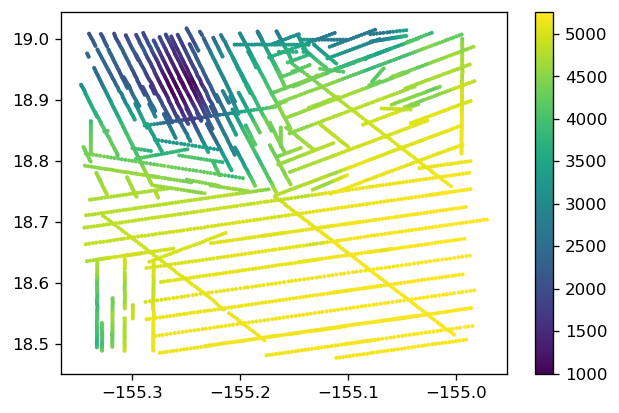

In [5]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

The survey recorded on the way to the study area but we only want the main survey, not the extra tracks.

In [6]:
data = data[vd.inside((data.LON, data.LAT), [-110, -106.5, -10, -5])]
# There are some NaNs that we need to remove
data = data.dropna(subset=["CORR_DEPTH"])
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
10241,EW9105,0,19910811,329.0,-8.44690,-106.50256,3,NaN,4.581,3425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.2,NaN,NaN,NaN
10242,EW9105,0,19910811,330.0,-8.44598,-106.50553,3,NaN,4.582,3426.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.8,NaN,NaN,NaN
10243,EW9105,0,19910811,331.0,-8.44501,-106.50851,3,NaN,4.553,3404.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.4,NaN,NaN,NaN
10244,EW9105,0,19910811,332.0,-8.44406,-106.51150,3,NaN,4.461,3334.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.4,NaN,NaN,NaN
10245,EW9105,0,19910811,333.0,-8.44314,-106.51451,3,NaN,4.443,3321.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59623,EW9105,0,19910914,900.0,-9.98789,-107.83760,3,NaN,4.637,3468.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.3,NaN,NaN,NaN
59624,EW9105,0,19910914,901.0,-9.99091,-107.83781,3,NaN,4.628,3461.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19.8,NaN,NaN,NaN
59625,EW9105,0,19910914,902.0,-9.99393,-107.83800,3,NaN,4.622,3456.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19.6,NaN,NaN,NaN
59626,EW9105,0,19910914,903.0,-9.99694,-107.83819,3,NaN,4.614,3450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19.8,NaN,NaN,NaN


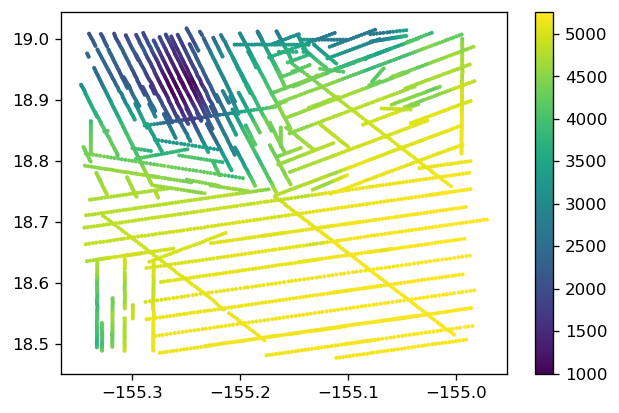

In [6]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

<a id="projections"></a>

## Projections

The coordinates are latitude and longitude but most methods in Verde work in Cartesian coordinates (this is being addressed in [#249](https://github.com/fatiando/verde/issues/249) and [#173](https://github.com/fatiando/verde/issues/173)).
So we need to project the data using `pyproj`.

In [7]:
projection = pyproj.Proj(proj="merc", lat_ts=data.LAT.mean())

In [8]:
coordinates = projection(data.LON.values, data.LAT.values)

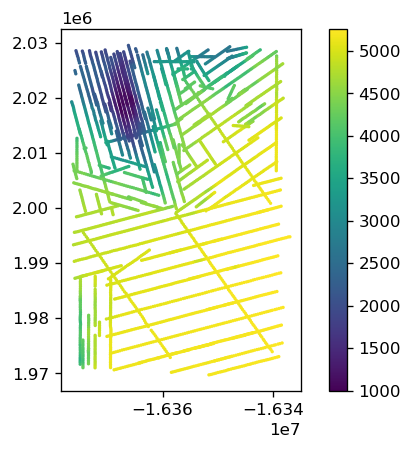

In [9]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=data.CORR_DEPTH, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="trends"></a>

## Trends

A common processing step is the removal of 2D polyomial trends from the data. This often helps interpolation methods which can struggle to recover the long wavelengths of data.

In [201]:
trend = vd.Trend(degree=2)

In [202]:
trend.fit(coordinates, data.CORR_DEPTH)

Trend(degree=2)

In [203]:
regional = trend.predict(coordinates)

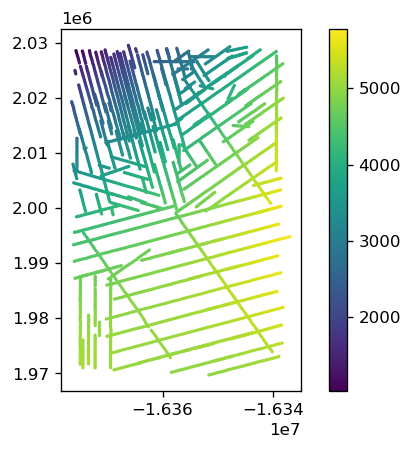

In [204]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=regional, s=1)
plt.axis("scaled")
plt.colorbar()

In [205]:
residual = data.CORR_DEPTH - regional

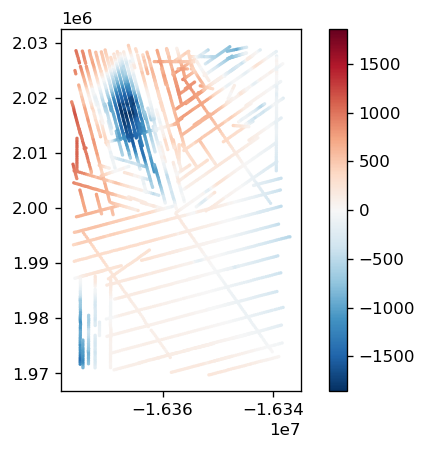

In [206]:
scale = vd.maxabs(residual)
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=residual, s=1, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.axis("scaled")
plt.colorbar()

<a id="reduction"></a>

## Blocked reductions

Shipborne and airborne data are usually oversampled along the tracks. 
This can lead to aliasing when performing interpolations.
To deal with this, we need to decimate the data to a more reasonable spacing.
One way to do this to take the median value along spatial blocks.

In [182]:
reducer = vd.BlockReduce(np.median, spacing=1000)

In [183]:
block_coords, block_bathymetry = reducer.filter(coordinates, data.CORR_DEPTH)

In [184]:
data.shape

(4503, 26)

In [185]:
block_bathymetry.shape

(1342,)

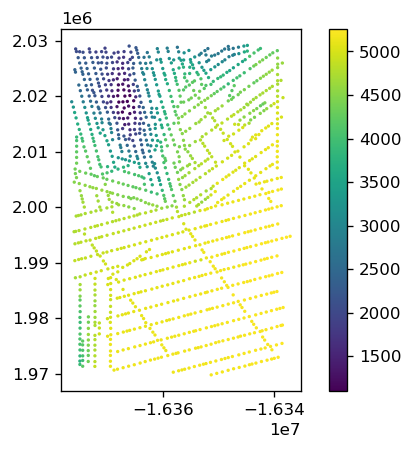

In [186]:
plt.figure()
plt.scatter(block_coords[0], block_coords[1], c=block_bathymetry, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="gridding"></a>

## Gridding with splines

Now that we have decimated data, we can fit a bi-harmonic spline model to it and use the model to predict observations (which is how we do interpolation). 
The spline model is:

$$g(\mathbf{x}) = \|\mathbf{x}\|^2 \left(\log \|\mathbf{x}\| - 1\right)$$

**WARNING**:
The Verde spline interpolation can be quite heavy on RAM usage (scaling with N²) so be careful using small blocks in the decimation process.
We are actively working to break out of these limits but that is still a reseach question being tackled at the [Computer-Oriented Geoscience Lab](https://www.compgeolab.org/).

In [34]:
spline = vd.Spline()

In [35]:
spline.fit(block_coords, block_bathymetry)

Spline()

In [36]:
predicted = spline.predict(coordinates)

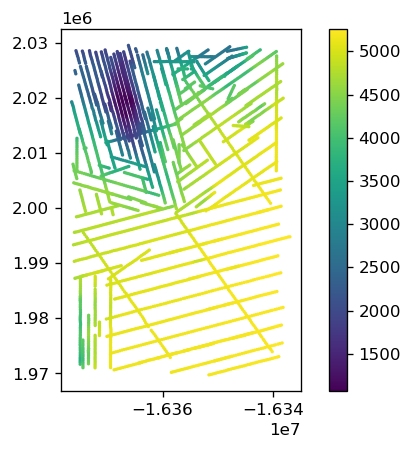

In [37]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=predicted, s=1)
plt.axis("scaled")
plt.colorbar()

In [38]:
spline_residual = data.CORR_DEPTH - predicted

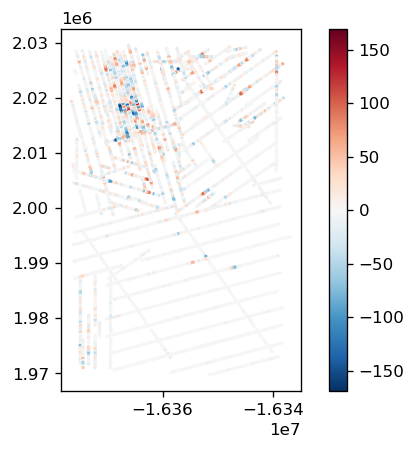

In [39]:
scale = vd.maxabs(spline_residual)

plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=spline_residual, s=1, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.axis("scaled")
plt.colorbar()

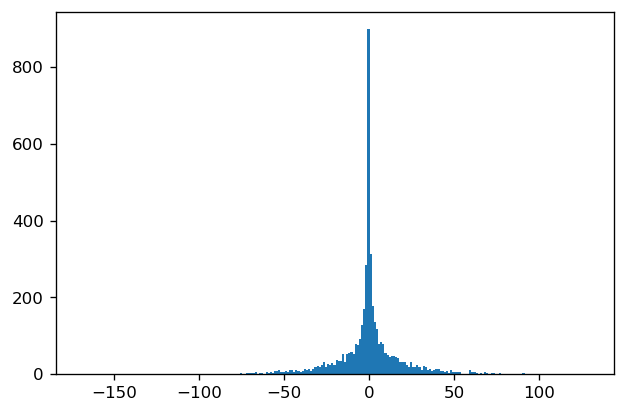

In [40]:
plt.figure()
plt.hist(spline_residual, bins="auto")
plt.show()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# ☕ Break (20 min)
    
</div>

## Gridding with splines (continued)

Now that we have a fitted spline, we can use it to generate gridded data.

In [187]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=500)

In [188]:
grid_bathymetry = spline.predict(grid_coords)

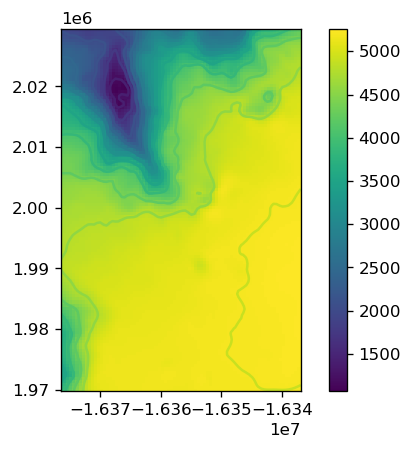

In [189]:
plt.figure()
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_bathymetry)
plt.axis("scaled")
plt.colorbar()
plt.contour(grid_coords[0], grid_coords[1], grid_bathymetry, levels=10)

An easier way to do this is through the `grid` method. It generated an `xarray.Dataset` with a predicted grid using the data region by default.

In [190]:
grid = spline.grid(spacing=500, data_names=["bathymetry"])

In [191]:
grid

<xarray.Dataset>
Dimensions:     (easting: 80, northing: 120)
Coordinates:
  * easting     (easting) float64 -1.638e+07 -1.638e+07 ... -1.634e+07
  * northing    (northing) float64 1.97e+06 1.97e+06 ... 2.029e+06 2.029e+06
Data variables:
    bathymetry  (northing, easting) float64 3.809e+03 3.945e+03 ... 4.18e+03
Attributes:
    metadata:  Generated by Spline()

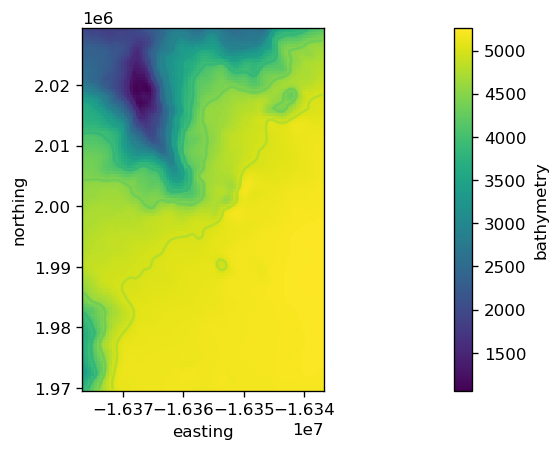

In [192]:
grid.bathymetry.plot()
plt.axis("scaled")
grid.bathymetry.plot.contour(levels=10)

<a id="chain"></a>

## Chainning operations

A common workflow is:

1. Remove a trend from the data
2. Decimate using a blocked mean/median
3. Fit a spline to the decimated residuals
4. Restore the trend when predicting values

This can be encapsulated into a single gridder using `Chain`.

In [251]:
chain = vd.Chain([
    ("trend", vd.Trend(degree=2)),
    ("reduce", vd.BlockReduce(np.median, spacing=1000)),
    ("spline", vd.Spline()),
])

In [252]:
chain.fit(coordinates, data.CORR_DEPTH)

Chain(steps=[('trend', Trend(degree=2)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7ff7789f1e18>,
                          spacing=1000)),
             ('spline', Spline())])

`Chain` is like any other gridder.

In [253]:
grid = chain.grid(spacing=500, data_names=["bathymetry"])
grid

<xarray.Dataset>
Dimensions:     (easting: 80, northing: 120)
Coordinates:
  * easting     (easting) float64 -1.638e+07 -1.638e+07 ... -1.634e+07
  * northing    (northing) float64 1.97e+06 1.97e+06 ... 2.029e+06 2.029e+06
Data variables:
    bathymetry  (northing, easting) float64 3.858e+03 3.979e+03 ... 4.242e+03
Attributes:
    metadata:  Generated by Chain(steps=[('trend', Trend(degree=2)),\n       ...

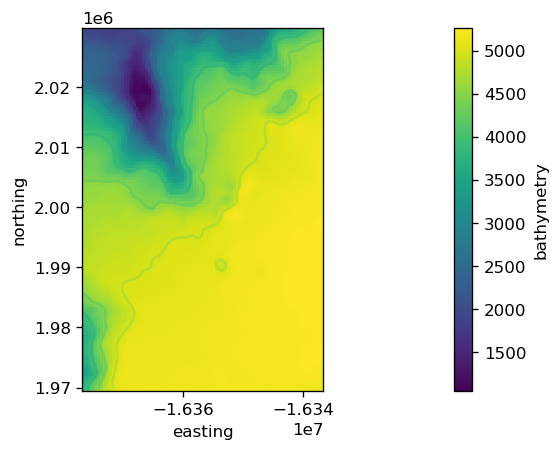

In [254]:
grid.bathymetry.plot()
plt.axis("scaled")
grid.bathymetry.plot.contour(levels=10)

<a id="train-test-split"></a>

## Training and validation split

A question remaining is "How accurate are our predictions?". To find out, we need to validate new data. 
If we don't have new data, we can hold out a part of the data from the gridding and use it to validate.

In [255]:
train, test = vd.train_test_split(coordinates, data.CORR_DEPTH, random_state=0, test_size=0.1)

In [256]:
train

((array([-16353437.53969262, -16343605.14000913, -16361545.28987656, ...,
         -16356550.55312301, -16369017.36545891, -16362143.01375568]),
  array([2020817.41304164, 1983740.94029267, 2016433.09130106, ...,
         1995519.51237869, 2017382.31088736, 2025869.88121767])),
 (array([4386, 5217, 3042, ..., 5024, 1835, 2922]),),
 (None,))

(-16378457.344130041,
 -16334931.555094823,
 1966757.4613804508,
 2032475.537994023)

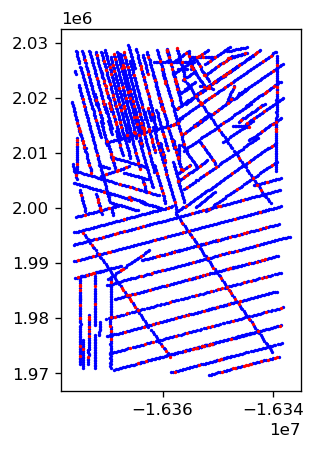

In [257]:
plt.figure()
plt.plot(train[0][0], train[0][1], ".b", markersize=2)
plt.plot(test[0][0], test[0][1], ".r", markersize=2)
plt.axis("scaled")

In [258]:
chain.fit(*train)

Chain(steps=[('trend', Trend(degree=2)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7ff7789f1e18>,
                          spacing=1000)),
             ('spline', Spline())])

Now we can score the interpolation pipeline on the test data. `score` calculated the R² coefficient of determination.

In [259]:
chain.score(*test)

0.9993497949937362

How realistic is this score? 
Turns out, not very much since our data are spatially autocorrelated. 
A better strategy is to split along spatial blocks to properly analyse the accuracy of extrapolation.

In [260]:
train, test = vd.train_test_split(coordinates, data.CORR_DEPTH, spacing=5e3, random_state=2, test_size=0.1)

(-16378457.344130041,
 -16334931.555094823,
 1966757.4613804508,
 2032475.537994023)

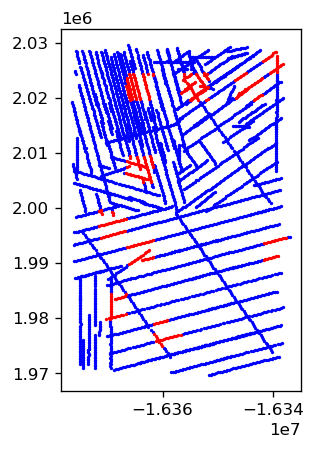

In [261]:
plt.figure()
plt.plot(train[0][0], train[0][1], ".b", markersize=2)
plt.plot(test[0][0], test[0][1], ".r", markersize=2)
plt.axis("scaled")

In [262]:
chain.fit(*train)

Chain(steps=[('trend', Trend(degree=2)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7ff7789f1e18>,
                          spacing=1000)),
             ('spline', Spline())])

In [263]:
chain.score(*test)

0.9892736477351656

<a id="cv"></a>

## Cross-validation

Splitting randomly has it's share of problems. 
It's a single snapshot of the accuracy and doesn't cover the whole datasets.
Cross-validation is a better strategy but it requires more fit-predict steps so takes longer.

Verde has a spatially blocked version of the popular k-fold cross-validation:

[![BlockKFold](https://www.fatiando.org/verde/v1.5.0/_images/sphx_glr_blockkfold_001.png)](https://www.fatiando.org/verde/v1.5.0/gallery/blockkfold.html)

In [264]:
cv = vd.BlockKFold(spacing=5e3, n_splits=10, shuffle=True, random_state=2)

In [265]:
%%time
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv)

CPU times: user 27.5 s, sys: 13.4 s, total: 40.9 s
Wall time: 5.21 s


In [266]:
scores

array([0.99691385, 0.98968644, 0.99713238, 0.98957454, 0.99352231,
       0.98373235, 0.93137223, 0.98542026, 0.99589405, 0.99488987])

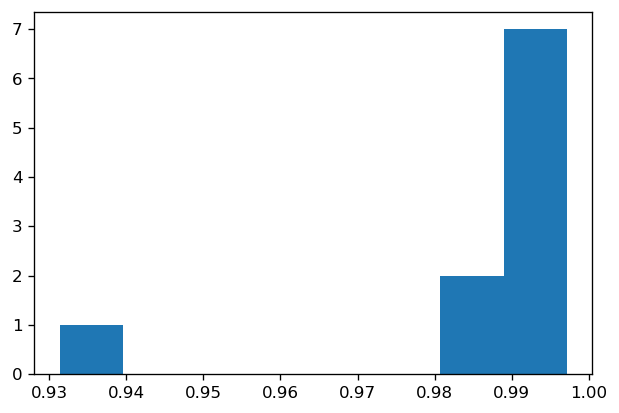

In [267]:
plt.figure()
plt.hist(scores, bins="auto")
plt.show()

<a id="splinecv"></a>

## Configuring the spline

The Verde spline has configuration options that impact the performance of the interpolation. Mainly:

* `mindist`: a distance threshold which controls the smoothness of the predictions
* `damping`: regularization parameter to stabilize the solutions

These values have defaults which may not work well for every scenario.

In [82]:
vd.Spline?

Init signature: vd.Spline(mindist=1e-05, damping=None, force_coords=None, engine='auto')
Docstring:     
Biharmonic spline interpolation using Green's functions.

This gridder assumes Cartesian coordinates.

Implements the 2D splines of [Sandwell1987]_. The Green's function for the
spline corresponds to the elastic deflection of a thin sheet subject to a
vertical force. For an observation point at the origin and a force at the
coordinates given by the vector :math:`\mathbf{x}`, the Green's function
is:

.. math::

    g(\mathbf{x}) = \|\mathbf{x}\|^2 \left(\log \|\mathbf{x}\| - 1\right)

In practice, this function is not defined for data points that coincide
with a force. To prevent this, a fudge factor is added to
:math:`\|\mathbf{x}\|`.

The interpolation is performed by estimating forces that produce
deflections that fit the observed data (using least-squares). Then, the
interpolated points can be evaluated at any location.

By default, the forces will be placed at the same points a

In [272]:
chain = vd.Chain([
    ("trend", vd.Trend(degree=2)),
    ("reduce", vd.BlockReduce(np.median, spacing=1000)),
    ("spline", vd.Spline(damping=1e-5, mindist=100)),
])

In [269]:
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv)
scores

array([0.99066883, 0.98102299, 0.99070592, 0.94996374, 0.98733159,
       0.9665356 , 0.89863598, 0.97652357, 0.99277003, 0.98871322])

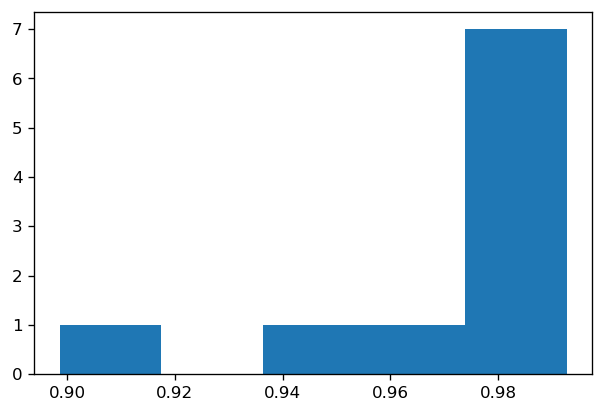

In [270]:
plt.figure()
plt.hist(scores, bins="auto")
plt.show()

In [274]:
chaincv = vd.Chain([
    ("trend", vd.Trend(degree=2)),
    ("reduce", vd.BlockReduce(np.median, spacing=1000)),
    ("spline", vd.SplineCV(
        dampings=[1e-8, 1e-5, 1e-3], mindists=[0.5e3, 1e3, 5e3], cv=cv, delayed=True)
    ),
])

In [275]:
chaincv.fit(*train)
chaincv.score(*test)

0.9889401334242469

In [276]:
chaincv.named_steps["spline"].damping_, chaincv.named_steps["spline"].mindist_

(1e-08, 5000.0)

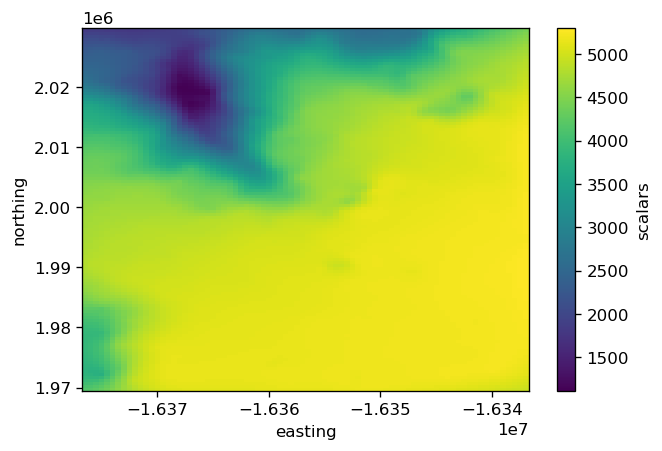

In [277]:
chaincv.grid(spacing=500).scalars.plot()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# Wrap up and work on your own data
    
</div>

## License

All code and text in this notebook is free software: you can redistribute it and/or
modify it under the terms of the BSD 3-clause License.
A copy of this license is provided in [LICENSE](https://github.com/fatiando/transform2020/blob/master/LICENSE).